# Импорты и настройки

In [1]:
from datasets import load_dataset

from preprocessing.augmentation_pipeline import AugmentationPipeline
from preprocessing.configs import PipelineConfig
from preprocessing.transforms import (
    BadPhotoCopyAugmentation,
    DilationAugmentation,
    ElasticTransformAugmentation,
    ErosionAugmentation,
    GridDistortionAugmentation,
    MotionBlurAugmentation,
    ScaleAugmentation,
    ScribblesAugmentation,
    ShearAugmentation,
    WaterMarkAugmentation,
)

import os
import re
import random
from dataclasses import dataclass
from typing import Any, Dict, List, Sequence, Union

import numpy as np
import torch
from datasets import load_dataset
from PIL import Image

from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
)

/home/nortlite/mipt/practice/cyrill/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-19 11:05:33.102919: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 11:05:33.132887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 11:05:33.742456: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see 

# Загрузка датасета и предобработка данных

In [2]:
ds = load_dataset("Timka28/cyrillic_small")

Repo card metadata block was not found. Setting CardData to empty.


## Настройка пайплайна аугментаций

In [3]:
aug_config = PipelineConfig(
    p_aug=0.5,
    augmentations={
        'bad_photo': BadPhotoCopyAugmentation(),
        'dilation': DilationAugmentation(),
        'elastic_transform': ElasticTransformAugmentation(),
        'erosion_augmentation': ErosionAugmentation(),
        'grid_distortion': GridDistortionAugmentation(),
        'motion_blur': MotionBlurAugmentation(),
        'scale': ScaleAugmentation(),
        'scribbles': ScribblesAugmentation(),
    },
    return_params=True
)

aug_pipeline = AugmentationPipeline(config=aug_config, seed=42)

# Пайплайн обучения

## Конфигурация

In [4]:
SEED = 42
MODEL_NAME = "microsoft/trocr-small-handwritten"
DATASET_NAME = "Timka28/cyrillic_small"

OUTPUT_DIR = "./trocr_cyrillic_small_ft"

TEST_SIZE = 0.2

MAX_TARGET_LENGTH = 512
GEN_MAX_LENGTH = 512


FP16 = True
NUM_EPOCHS = 70
LR = 5e-5
TRAIN_BS = 8
EVAL_BS = 8
GRAD_ACCUM = 1

DATALOADER_WORKERS = 4

## Утилиты: нормализация + расстояния Левенштейна

In [5]:
_ws_re = re.compile(r"\s+")

def normalize_text(s: str) -> str:
    # минимальная нормализация: убрать лишние пробелы/переводы строк
    s = s.replace("\u00A0", " ")   # non-breaking space
    s = s.replace("\n", " ").replace("\r", " ").replace("\t", " ")
    s = _ws_re.sub(" ", s).strip()
    return s

def levenshtein(seq_a: Union[str, Sequence[Any]], seq_b: Union[str, Sequence[Any]]) -> int:
    """
    Levenshtein distance.
    Работает и для строк, и для списков токенов (слов).
    """
    a = seq_a
    b = seq_b
    if a == b:
        return 0
    len_a = len(a)
    len_b = len(b)
    if len_a == 0:
        return len_b
    if len_b == 0:
        return len_a

    # делаем b короче для экономии памяти
    if len_a < len_b:
        a, b = b, a
        len_a, len_b = len_b, len_a

    prev = list(range(len_b + 1))
    for i in range(1, len_a + 1):
        cur = [i]
        ca = a[i - 1]
        for j in range(1, len_b + 1):
            cb = b[j - 1]
            ins = cur[j - 1] + 1
            delete = prev[j] + 1
            sub = prev[j - 1] + (0 if ca == cb else 1)
            cur.append(min(ins, delete, sub))
        prev = cur
    return prev[-1]

def right_metrics(pred_texts: List[str], ref_texts: List[str]) -> Dict[str, float]:
    """
    right_symbols: доля правильно распознанных символов (через edit distance по символам)
    right_words:   доля правильно распознанных слов (через edit distance по словам)
    """
    total_chars = 0
    correct_chars = 0

    total_words = 0
    correct_words = 0

    for p, t in zip(pred_texts, ref_texts):
        p = normalize_text(p)
        t = normalize_text(t)

        # symbols
        if len(t) > 0:
            d = levenshtein(p, t)
            total_chars += len(t)
            correct_chars += max(len(t) - d, 0)

        # words
        t_words = t.split()
        p_words = p.split()
        if len(t_words) > 0:
            d_w = levenshtein(p_words, t_words)
            total_words += len(t_words)
            correct_words += max(len(t_words) - d_w, 0)

    right_symbols = (correct_chars / total_chars) if total_chars > 0 else 0.0
    right_words = (correct_words / total_words) if total_words > 0 else 0.0
    return {"right_symbols": right_symbols, "right_words": right_words}


## Collator

In [6]:
@dataclass
class DataCollatorForTrOCR:
    processor: TrOCRProcessor

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        pixel_values = torch.stack([f["pixel_values"] for f in features])

        labels = [f["labels"] for f in features]
        labels_padded = self.processor.tokenizer.pad(
            {"input_ids": labels},
            padding=True,
            return_tensors="pt",
        )["input_ids"]

        labels_padded[labels_padded == self.processor.tokenizer.pad_token_id] = -100

        return {"pixel_values": pixel_values, "labels": labels_padded}

## Обучение

Device: cuda


Repo card metadata block was not found. Setting CardData to empty.


Train size: 4425 Test size: 1107


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 0}.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call_

Step,Training Loss
1000,4.313300
2000,3.711000
3000,3.582200
4000,3.459700
5000,3.385900
6000,3.320000
7000,3.208500
8000,3.170000
9000,3.122000
10000,3.053000


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with 

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



=== FINAL METRICS ===
TRAIN: {}
TRAIN right_words: 0.008306285554741213
TRAIN right_symbols: 0.19018595495733262

TEST right_words: 0.0035671819262782403
TEST right_symbols: 0.1667991675824818

=== DEMO SAMPLE ===
GT: репертуаре балетных 
PR: наедга доы вслх 


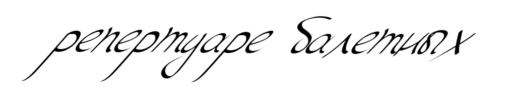

In [7]:
def main():
    set_seed(SEED)
    torch.backends.cuda.matmul.allow_tf32 = True

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    # 1) Load dataset and split 80/20
    raw = load_dataset(DATASET_NAME)  # есть только split=train, делаем свой split
    ds = raw["train"].train_test_split(test_size=TEST_SIZE, seed=SEED, shuffle=True)

    # оставим только нужные колонки
    keep_cols = ["image", "text"]
    train_raw = ds["train"].remove_columns([c for c in ds["train"].column_names if c not in keep_cols])
    test_raw  = ds["test"].remove_columns([c for c in ds["test"].column_names if c not in keep_cols])

    print("Train size:", len(train_raw), "Test size:", len(test_raw))

    # 2) Load processor + model
    processor = TrOCRProcessor.from_pretrained(MODEL_NAME)
    model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)

    # важные config-поля для VisionEncoderDecoder
    model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
    model.config.eos_token_id = processor.tokenizer.sep_token_id
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    model.config.vocab_size = model.config.decoder.vocab_size
    model.config.max_length = GEN_MAX_LENGTH

    model.to(device)

    # 3) Transforms (on-the-fly)
    def transform(batch):
        images = []
        for idx, img in enumerate(batch["image"]):
            # здесь применяем аугментации
            img = aug_pipeline(img, idx=idx)[0]
            if isinstance(img, Image.Image):
                pil = img
            else:
                pil = Image.fromarray(np.array(img))
            images.append(pil.convert("RGB"))

        pixel_values = processor(images=images, return_tensors="pt").pixel_values

        # labels: токенизация текста
        texts = [t if t is not None else "" for t in batch["text"]]
        tokenized = processor.tokenizer(
            texts,
            truncation=True,
            max_length=MAX_TARGET_LENGTH,
            padding=False,
        )

        return {
            "pixel_values": pixel_values,
            "labels": tokenized["input_ids"],
        }

    train_ds = train_raw.with_transform(transform)
    test_ds = test_raw.with_transform(transform)

    data_collator = DataCollatorForTrOCR(processor)

    # 4) Metrics for Trainer
    def compute_metrics(eval_pred):
        preds = eval_pred.predictions
        labels = eval_pred.label_ids

        # Seq2SeqTrainer иногда возвращает tuple
        if isinstance(preds, tuple):
            preds = preds[0]

        labels = np.where(labels == -100, processor.tokenizer.pad_token_id, labels)

        pred_str = processor.batch_decode(preds, skip_special_tokens=True)
        label_str = processor.batch_decode(labels, skip_special_tokens=True)

        m = right_metrics(pred_str, label_str)
        return {
            "right_words": m["right_words"],
            "right_symbols": m["right_symbols"],
        }

    # 5) TrainingArguments + Trainer
    args = Seq2SeqTrainingArguments(
        output_dir=OUTPUT_DIR,
        seed=SEED,

        learning_rate=LR,
        num_train_epochs=NUM_EPOCHS,

        per_device_train_batch_size=TRAIN_BS,
        per_device_eval_batch_size=EVAL_BS,
        gradient_accumulation_steps=GRAD_ACCUM,

        fp16=FP16,
        bf16=False,

        predict_with_generate=True,
        generation_max_length=GEN_MAX_LENGTH,
        save_strategy="epoch",
        logging_strategy="steps",
        logging_steps=1000,

        save_total_limit=2,

        dataloader_num_workers=DATALOADER_WORKERS,
        remove_unused_columns=False,
        report_to="none",
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        data_collator=data_collator,
        tokenizer=processor.tokenizer,
        compute_metrics=compute_metrics,
    )

    # 6) Train (с метриками на test на каждой эпохе)
    trainer.train()

    # 7) Финальные метрики на train и test (как вы просили)
    train_pred = trainer.predict(train_ds, max_length=GEN_MAX_LENGTH)
    test_pred  = trainer.predict(test_ds,  max_length=GEN_MAX_LENGTH)

    print("\n=== FINAL METRICS ===")
    print("TRAIN:", {k: float(v) for k, v in train_pred.metrics.items() if k.startswith("test_") is False})
    # trainer.predict кладёт метрики в dict вида {"test_right_words":...} (для любого predict)
    # поэтому распечатаем явно:
    print("TRAIN right_words:", float(train_pred.metrics.get("test_right_words", 0.0)))
    print("TRAIN right_symbols:", float(train_pred.metrics.get("test_right_symbols", 0.0)))

    print("\nTEST right_words:", float(test_pred.metrics.get("test_right_words", 0.0)))
    print("TEST right_symbols:", float(test_pred.metrics.get("test_right_symbols", 0.0)))

    # 8) Демонстрация распознавания одной картинки
    idx = random.randrange(len(test_raw))
    sample = test_raw[idx]
    image = sample["image"].convert("RGB")
    gt_text = sample["text"]

    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        generated_ids = model.generate(inputs.pixel_values, max_length=GEN_MAX_LENGTH)
    pred_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    print("\n=== DEMO SAMPLE ===")
    print("GT:", normalize_text(gt_text)[:500], "..." if len(gt_text) > 500 else "")
    print("PR:", normalize_text(pred_text)[:500], "..." if len(pred_text) > 500 else "")

    try:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.imshow(image)
        plt.axis("off")
        plt.show()
    except Exception:
        pass

main()